## Disclaimer

NO FINANCIAL ADVICE - The content is for informational purposes only, you should not construe any such information or other material as legal, tax, investment, financial, or other advice. Nothing contained on this file constitutes a solicitation, recommendation, endorsement, or offer by me or any third party service provider to buy or sell any securities or other financial instruments in this or in in any other jurisdiction in which such solicitation or offer would be unlawful under the securities laws of such jurisdiction. Any decision remain your own and I am not responsible for any losses or gains made.

All content on this file is information of a general nature and does not address the circumstances of any particular individual or entity. Nothing in the file constitutes professional and/or financial advice, nor does any information on the file constitute a comprehensive or complete statement of the matters discussed or the law relating thereto.
YOU SHOULD NOT MAKE ANY DECISION, FINANCIAL, INVESTMENTS, TRADING OR OTHERWISE, BASED ON ANY OF THE INFORMATION PRESENTED FROM THIS PROGRAM WITHOUT UNDERTAKING INDEPENDENT DUE DILIGENCE AND CONSULTATION WITH A PROFESSIONAL BROKER OR COMPETENT FINANCIAL ADVISOR. By using any information available on or through this file you understand that you are AT YOUR OWN RISK.

RISK STATEMENT - There are risks associated with investing in securities. Investing in stocks, bonds, exchange traded funds, mutual funds, and money market funds involve risk of loss. Loss of principal is possible. Some high risk investments may use leverage, which will accentuate gains & losses. Foreign investing involves special risks, including a greater volatility and political, economic and currency risks and differences in accounting methods. Trading may not be suitable for all users. A security’s or a firm’s past investment performance is not a guarantee or predictor of future investment performance.

In [60]:
import pandas as pd
import numpy as np
from binance.client import Client
from datetime import datetime
from ta import add_all_ta_features
from ta.utils import dropna
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

from sklearn import model_selection as ms
import sklearn.metrics as mt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [61]:
# initialize
with open('api_key.txt','r') as f:
    api_key = f.read()
with open('api_secret.txt','r') as f:
    api_secret = f.read()

client = Client(api_key, api_secret)

In [223]:
#get current price
curr = 'BTCUSDT'
btc_price = client.get_symbol_ticker(symbol=curr)
print(btc_price)

{'symbol': 'BTCUSDT', 'price': '23029.61000000'}


In [64]:
#get historical data (d days back with 3m interval)
d = 120
ts = 1000*int(datetime.timestamp(datetime.now())-d*86400)
bars = client.get_historical_klines(curr, '3m', ts, limit=1000)

In [68]:
#create pandas dataframe
btc_df = pd.DataFrame(bars, columns=['Date', 'Open', 'High', 'Low', 'Close','Volume','CloseDate',
                                     'QAV','Trades','TBBAV','TBQAV','Ignore'])
btc_df.Date = btc_df.Date.astype('datetime64[ms]')
btc_df = btc_df.drop(['CloseDate','QAV','TBBAV','TBQAV','Ignore'],axis=1)
btc_df.set_index('Date', inplace=True)

for c in btc_df.columns:
    btc_df[c] = btc_df[c].astype(float)
btc_df

,Open,High,Low,Close,Volume,Trades
Date,,,,,,
2020-08-20 22:09:00,11825.76,11827.50,11820.29,11821.14,74.257198,1668.0
2020-08-20 22:12:00,11821.13,11825.06,11820.04,11823.89,42.708361,885.0
2020-08-20 22:15:00,11823.89,11824.72,11821.85,11822.98,54.211805,1109.0
2020-08-20 22:18:00,11822.98,11826.81,11817.73,11823.16,51.865486,996.0
2020-08-20 22:21:00,11823.45,11838.03,11821.75,11837.79,71.330969,1207.0
...,...,...,...,...,...,...
2020-12-18 21:54:00,22914.75,22915.77,22826.51,22873.30,223.139452,4075.0
2020-12-18 21:57:00,22873.31,22901.95,22872.30,22880.07,142.089809,2901.0
2020-12-18 22:00:00,22880.07,22931.25,22874.42,22927.20,137.400886,2855.0


In [14]:
#add technical analysis
ta_df = add_all_ta_features(
    btc_df, open="Open", high="High", low="Low", close="Close", volume="Volume")

ta_df.isna().sum()[ta_df.isna().sum()>80].keys()

ta_df3 = ta_df.copy()
ta_df2 = ta_df.drop(ta_df.isna().sum()[ta_df.isna().sum()>80].keys(),axis=1)
print(len(ta_df2.columns))
ta_df = ta_df2.dropna()
ta_df.head()

/opt/anaconda3/lib/python3.7/site-packages/ta/trend.py:608: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i]/self._trs[i])
/opt/anaconda3/lib/python3.7/site-packages/ta/trend.py:612: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i]/self._trs[i])


76


,Open,High,Low,Close,Volume,Trades,volume_adi,volume_obv,volume_cmf,volume_fi,...,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_kama,momentum_roc,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-22 01:00:00,3841.03,3844.98,3800.2,3823.23,1995.554354,12288.0,17857.735186,719.153228,-0.089532,-36829.346027,...,42.887125,19.293788,23.111502,-80.706212,-128.274647,3868.262688,-4.605032,-0.513406,-0.514729,3.470925
2018-12-22 02:00:00,3823.23,3844.02,3790.0,3841.63,1443.190681,10204.0,19173.224063,2162.343909,-0.091242,-27774.481090,...,53.312484,25.739390,23.584629,-74.260610,-121.756971,3866.721304,-3.927786,0.481268,0.480114,3.968898
2018-12-22 03:00:00,3841.63,3843.53,3816.5,3818.21,1154.849807,7520.0,18164.492878,1007.494102,-0.137144,-27670.495575,...,53.508303,20.095641,21.709606,-79.904359,-115.084294,3863.279960,-3.212224,-0.609637,-0.611503,3.335065
2018-12-22 04:00:00,3818.65,3832.38,3788.0,3804.74,1421.701323,8892.0,17815.314319,-414.207221,-0.138836,-26453.327181,...,47.753477,16.855606,20.896879,-83.144394,-112.531118,3858.708643,-3.064443,-0.352783,-0.353407,2.970517
2018-12-22 05:00:00,3804.74,3829.00,3785.0,3818.68,1324.976830,8518.0,18518.756564,910.769609,-0.101555,-20035.683725,...,52.675455,25.504921,20.818723,-74.495079,-115.454588,3858.317063,-2.583700,0.366385,0.365716,3.347785


In [18]:
#create sma df
m0 = ta_df.Close - ta_df.Close.rolling(1).mean()
m1 = ta_df.Close - ta_df.Close.rolling(2).mean()
m2 = ta_df.Close - ta_df.Close.rolling(3).mean()
m3 = ta_df.Close - ta_df.Close.rolling(5).mean()
m4 = ta_df.Close - ta_df.Close.rolling(7).mean()
m5 = ta_df.Close - ta_df.Close.rolling(9).mean()
m6 = ta_df.Close - ta_df.Close.rolling(12).mean()
m7 = ta_df.Close - ta_df.Close.rolling(24).mean()


sma_df = pd.concat([ta_df.Close,m0,m1,m2,m3,m4,m5,m6,m7],axis=1).dropna()
sma_df.columns = ['Close',1,2,3,5,7,9,12,24]
for i in [1,2,3,5,7,9,12,24]:
    sma_df = pd.concat([sma_df,np.sign(sma_df[i]).diff()/2],axis=1)
sma_df.columns = ['Close',1,2,3,5,7,9,12,24,'1i','2i','3i','5i','7i','9i','12i','24i']
sma_df['result'] = sma_df[['1i','2i','3i','5i','7i','9i','12i','24i']].sum(axis=1)
sma_df = sma_df.dropna()

In [19]:
sma_df

,Close,1,2,3,5,7,9,12,24,1i,2i,3i,5i,7i,9i,12i,24i,result
Date,,,,,,,,,,,,,,,,,,
2018-12-23 01:00:00,3963.52,-3.183231e-12,-6.845,0.306667,41.482,54.962857,69.361111,84.652500,101.686250,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
2018-12-23 02:00:00,3948.07,-3.637979e-12,-7.725,-14.863333,10.612,29.482857,41.598889,59.086667,81.801250,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0
2018-12-23 03:00:00,3980.97,-3.637979e-12,16.450,16.783333,17.234,46.794286,59.976667,79.414167,107.919583,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0
2018-12-23 04:00:00,3966.28,-3.637979e-12,-7.345,1.173333,-0.930,18.488571,35.462222,54.384167,86.498750,0.0,-1.0,0.0,-1.0,0.0,0.0,0.0,0.0,-2.0
2018-12-23 05:00:00,3977.99,-4.092726e-12,5.855,2.910000,10.624,11.854286,35.378889,54.366667,91.570833,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-18 17:00:00,22749.32,-1.673470e-10,15.020,76.786667,109.314,31.374286,-51.025556,-114.715000,-136.338333,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2020-12-18 18:00:00,22781.44,-1.709850e-10,16.060,31.426667,99.502,78.455714,29.025556,-64.840833,-84.683750,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2020-12-18 19:00:00,22762.28,-1.709850e-10,-9.580,-2.066667,50.016,84.601429,32.353333,-59.525833,-98.143750,0.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,-2.0


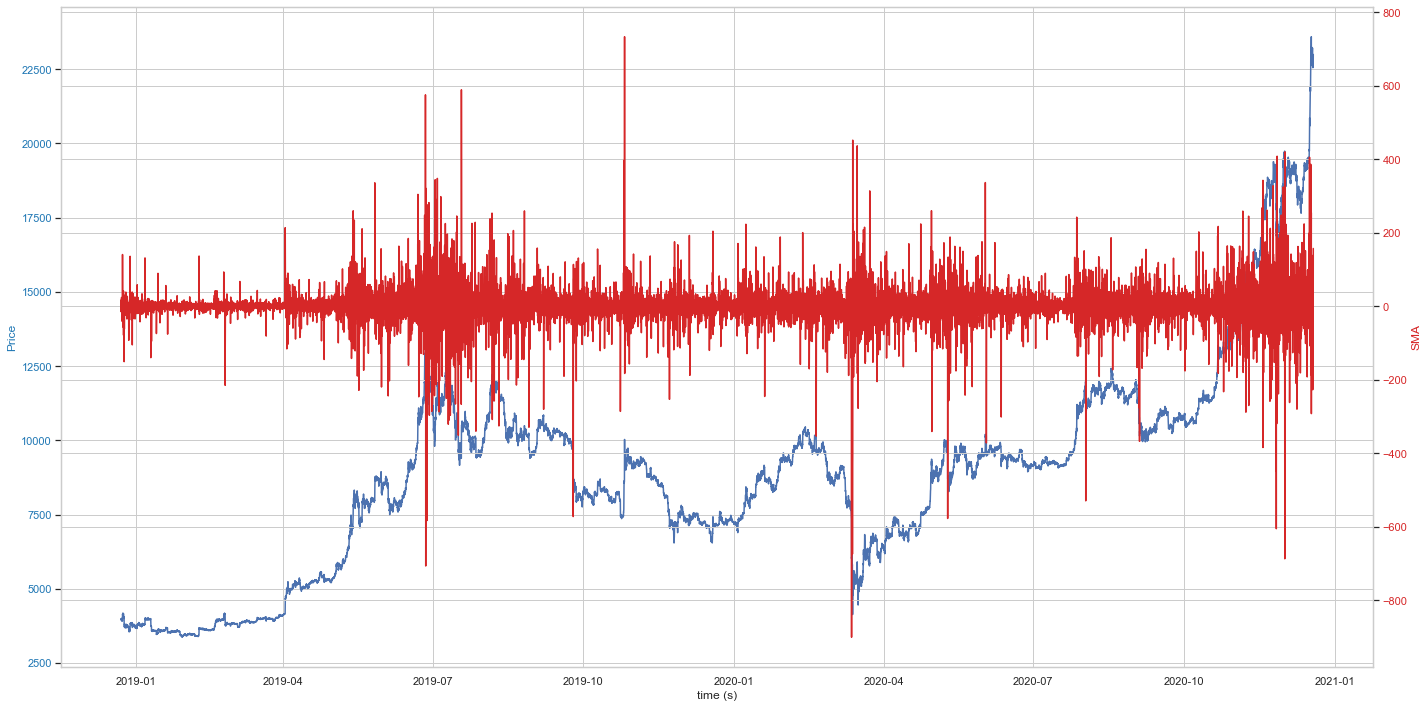

In [225]:
s1_df = sma_df
fig, ax1 = plt.subplots(figsize=(20,10))

color = 'tab:blue'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Price', color=color)
ax1.plot(s1_df.index,s1_df.Close)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('SMA', color=color)  # we already handled the x-label with ax1
ax2.plot(s1_df.index, s1_df[3], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Trade Simulation

In [54]:
#sim
s1_df = sma_df
comission = 0.999
buy=0
sell=0
queue='b'
capital = 100
coins = 0
ltp = 0
for val in s1_df[['Close',1,'7i']].values:
    if val[1]<0 and val[2]==-1 and queue=='b':
        #buy
        buy+=1
        coins = comission*capital/(val[0])
        capital = 0
        queue = 's'
        ltp = val[0]
        #print('coins',coins)
        
    elif val[1]>0 and val[2]==1 and queue=='s' and val[0]>ltp:
        #sell
        sell+=1
        capital = comission*coins*val[0]
        coins = 0
        #print('capital',capital)
        queue = 'b'
        ltp = val[0]

# Multi Analysis

In [ ]:
#get historical multiple data (d days back with 3m interval)
colnames_raw = ['Date', 'Open', 'High', 'Low', 'Close','Volume','CloseDate','QAV','Trades','TBBAV','TBQAV','Ignore']
d = 5
ts = 1000*int(datetime.timestamp(datetime.now())-d*86400)
currs = ['BTCUSDT','ETHUSDT','LTCUSDT','XRPUSDT','BCHUSDT']
all_df = pd.DataFrame()
for coin in currs:
    bars = client.get_historical_klines(coin, '1m', ts, limit=1000)
    colnames = [coin+'_'+cn for cn in colnames_raw]
    #create pandas dataframe
    coin_df = pd.DataFrame(bars, columns=colnames)
    coin_df[coin+'_Date'] = coin_df[coin+'_Date'].astype('datetime64[ms]')
    coin_df = coin_df.drop([coin+'_CloseDate',coin+'_QAV',coin+'_TBBAV',coin+'_TBQAV',coin+'_Ignore'],axis=1)
    coin_df.set_index(coin+'_Date', inplace=True)

    for c in coin_df.columns:
        coin_df[c] = coin_df[c].astype(float)
        
    
    all_df = pd.concat([all_df,coin_df],axis=1)
    print(coin)

In [ ]:
#try predicting next step with RandomForest - unsuccesful (as expected)
target = 'BTCUSDT_Close'

inv_df = all_df[[curr+'_Close' for curr in currs]]
inv_df = (inv_df.pct_change()>0).astype(int)

inv_df[target] = inv_df[target].shift(-1)
inv_df = inv_df.dropna()
X_train,X_test,y_train,y_test = ms.train_test_split(inv_df.drop(target,axis=1),inv_df[target])
model = RandomForestClassifier()
model.fit(X_train,y_train)
print(model.score(X_test,y_test))
mt.plot_confusion_matrix(model,X_test,y_test,normalize='true')

In [239]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def plot_moving_average(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    fig=plt.figure(figsize=(20,8))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        #print(series[window:])
        mae = mean_absolute_error(series[window:], rolling_mean[window:]) 
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        print(mae,deviation)
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

2.5553851549295796 ETHUSDT_Close    3.87991
dtype: float64


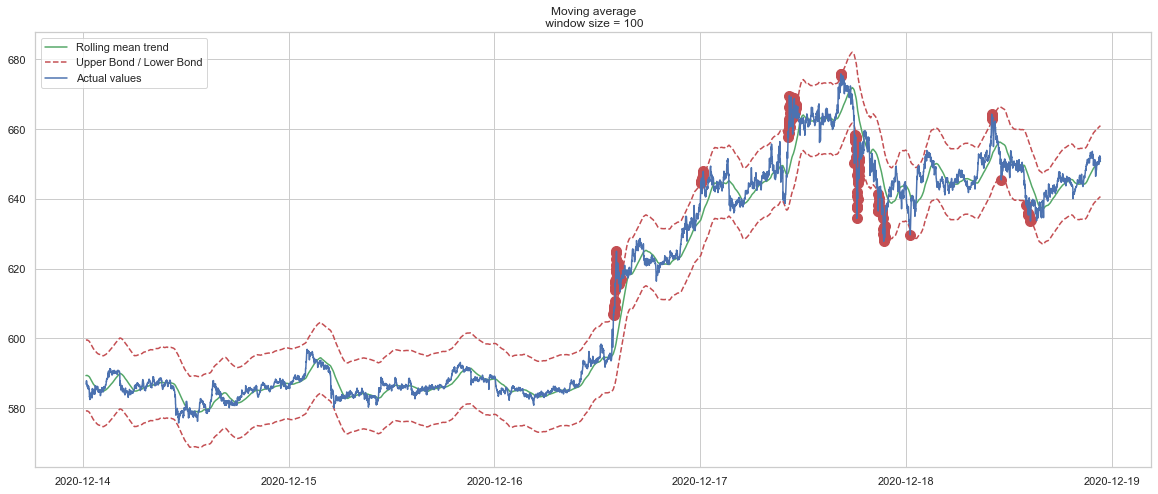

In [240]:
target = 'ETHUSDT_Close'
plot_moving_average(all_df[[target]],100,plot_intervals=True, plot_anomalies=True)